<a href="https://colab.research.google.com/github/JeanMusenga/TOSEM-2025-Submission/blob/main/BERT_14932PostsMixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://chatgpt.com/share/b8196226-48d6-49a4-b448-db1ac491d8a5

https://chatgpt.com/share/d4841f05-7b85-45ea-ae25-470f9c2482d0

https://chatgpt.com/share/2bebe31f-939c-4795-b536-da081784d48c

#https://chatgpt.com/share/2f5dfec4-026c-4017-944e-7720f539930f

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.7 MB/s eta 0:00:00


In [ ]:
!pip show datasets

Name: datasets
Version: 3.3.2
Summary: HuggingFace community-driven open-source library of datasets
Home-page: https://github.com/huggingface/datasets
Author: HuggingFace Inc.
Author-email: thomas@huggingface.co
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: aiohttp, dill, filelock, fsspec, huggingface-hub, multiprocess, numpy, packaging, pandas, pyarrow, pyyaml, requests, tqdm, xxhash
Required-by: evaluate


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch
#from datasets import Dataset, load_metric
from evaluate import load
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from datasets import Dataset
from torch.optim import AdamW
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import nltk
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer


# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Load the dataset

In [ ]:
# Load the dataset
dataset = pd.read_excel('14932_ARPs_and_Programming_Posts.xlsx')

In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup

# Function to remove HTML tags and replace links, images, code snippets, and tables with placeholders
def clean_html(text):
    if not isinstance(text, str):
        return text

    soup = BeautifulSoup(text, "html.parser")

    # Replace all links with '[external-link]'
    for a in soup.find_all('a'):
        a.replace_with('[external-link]')

    # Replace all images with '[figure]'
    for img in soup.find_all('img'):
        img.replace_with('[figure]')

    # Replace all code blocks with '[code-snippet]'
    for code in soup.find_all('code'):  # Fixed this line
        code.replace_with('[code-snippet]')

    # Replace all tables with '[table]'
    for table in soup.find_all('table'):
        table.replace_with('[table]')

    # Get the text without any remaining HTML tags
    clean_text = soup.get_text()

    return clean_text

# Load your DataFrame (assuming df is already defined)
# df = pd.read_csv('your_file.csv')  # Uncomment if loading from a file

# Apply the function to 'Question_body' column
dataset['Question_body_cleaned'] = dataset['Question_body'].apply(clean_html)


# Print sample cleaned data
print(dataset[['Question_body', 'Question_body_cleaned']].head())


                                       Question_body  \
0  <p>When deploying a Windows EC2 instance with ...   
1  I'm pretty new to my company (2 weeks) and we'...   
2  <p>I am trying to figure out how to get <code>...   
3  Say you have an application divided into 3-tie...   
4  <p>I am trying to use the circuit breaker patt...   

                               Question_body_cleaned  
0  When deploying a Windows EC2 instance with Ter...  
1  I'm pretty new to my company (2 weeks) and we'...  
2  I am trying to figure out how to get [code-sni...  
3  Say you have an application divided into 3-tie...  
4  I am trying to use the circuit breaker pattern...  


In [ ]:
# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Ensure the text is a string
    if not isinstance(text, str):
        text = str(text)

    # Tokenize text
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]  # Remove non-alphabetic tokens
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize words
    return ' '.join(lemmatized)


# Ensure all values in 'Question_body' are strings and handle NaNs and # Convert 'Question_body' to string (to avoid NaN issues)
dataset['Question_body_cleaned'] = dataset['Question_body_cleaned'].fillna('').astype(str)

# Apply the preprocessing function
dataset['Question_body_preprocessed'] = dataset['Question_body_cleaned'].apply(preprocess_text)


# Load the BERT tokenizer and model

In [ ]:
# Load Tokenizer and Model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Enable GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Tokenization function
def tokenize_function(dataset):
    tokens = tokenizer(
        dataset['Question_body_preprocessed'],
        padding='max_length',
        truncation=True,
        max_length=64  # Reduced from 128
    )
    tokens["labels"] = dataset["labels"]
    return tokens


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Split the dataset

In [ ]:
# Split dataset
train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=42)

# Ensure labels are integers
train_df['labels'] = train_df['Label'].astype(int)
test_df['labels'] = test_df['Label'].astype(int)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Filter out any problematic rows
train_dataset = train_dataset.filter(lambda x: isinstance(x['Question_body_preprocessed'], str))
test_dataset = test_dataset.filter(lambda x: isinstance(x['Question_body_preprocessed'], str))

# Tokenize
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Speed up data loading
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Filter:   0%|          | 0/11945 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2987 [00:00<?, ? examples/s]

Map:   0%|          | 0/11945 [00:00<?, ? examples/s]

Map:   0%|          | 0/2987 [00:00<?, ? examples/s]

# Define Training Arguments

In [ ]:
# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=64,  # Increased batch size
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=3e-5,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    max_grad_norm=1.0,
    gradient_accumulation_steps=2,
    lr_scheduler_type="linear",
    load_best_model_at_end=True,
    report_to="none",
    fp16=True  # Enable mixed precision for speed
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



# Define Trainer

In [ ]:
# Data Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator
)



# Train the BERT Model

In [ ]:
# Train
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.393900,0.371393
2,0.221900,0.169353


TrainOutput(global_step=279, training_loss=0.34507080090088654, metrics={'train_runtime': 137.2674, 'train_samples_per_second': 261.06, 'train_steps_per_second': 2.033, 'total_flos': 1168805085672960.0, 'train_loss': 0.34507080090088654, 'epoch': 2.9732620320855614})

# Evaluate the Model

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Get model predictions
predictions = trainer.predict(test_dataset)

# Ensure the correct extraction of predictions and labels
y_pred = predictions.predictions.argmax(-1)
y_true = test_dataset["labels"]  # Ensure direct access to labels

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Class 0 - Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1 score: {f1[0]:.4f}')
print(f'Class 1 - Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1 score: {f1[1]:.4f}')


Accuracy: 0.9354
Class 0 - Precision: 0.9223, Recall: 0.9512, F1 score: 0.9365
Class 1 - Precision: 0.9494, Recall: 0.9195, F1 score: 0.9342


## Overall: BERT

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Get model predictions
predictions = trainer.predict(test_dataset)

# Ensure the correct extraction of predictions and labels
y_pred = predictions.predictions.argmax(-1)
y_true = test_dataset["labels"]  # Ensure direct access to labels

# Compute evaluation metrics (overall metrics)
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

# Print results
print(f'Overall Accuracy: {accuracy:.4f}')
print(f'Overall Precision: {precision:.4f}')
print(f'Overall Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Overall Accuracy: 0.9354
Precision: 0.9494
Recall: 0.9195
F1 Score: 0.9342


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score

# Compute metrics for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Extract TP, FP, FN, TN for each class
TP_0, FN_0 = conf_matrix[0, 0], conf_matrix[0, 1]
FP_0, TN_0 = conf_matrix[1, 0], conf_matrix[1, 1]

TP_1, FN_1 = conf_matrix[1, 1], conf_matrix[1, 0]
FP_1, TN_1 = conf_matrix[0, 1], conf_matrix[0, 0]

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_true, y_pred)

# Compute specificity (True Negative Rate) for each class
specificity_0 = TN_0 / (TN_0 + FP_0) if (TN_0 + FP_0) != 0 else 0.0
specificity_1 = TN_1 / (TN_1 + FP_1) if (TN_1 + FP_1) != 0 else 0.0

# Print results
print(f'Overall Accuracy: {overall_accuracy:.4f}')
print(f'Class 0 - Precision: {precision_class[0]:.4f}, Recall (TPR): {recall_class[0]:.4f}, Specificity (TNR): {specificity_0:.4f}, F1-score: {f1_class[0]:.4f}')
print(f'Class 1 - Precision: {precision_class[1]:.4f}, Recall (TPR): {recall_class[1]:.4f}, Specificity (TNR): {specificity_1:.4f}, F1-score: {f1_class[1]:.4f}')


Overall Accuracy: 0.9354
Class 0 - Precision: 0.9223, Recall (TPR): 0.9512, Specificity (TNR): 0.9195, F1-score: 0.9365
Class 1 - Precision: 0.9494, Recall (TPR): 0.9195, Specificity (TNR): 0.9512, F1-score: 0.9342


## Ploting the Cnfusion Matrix

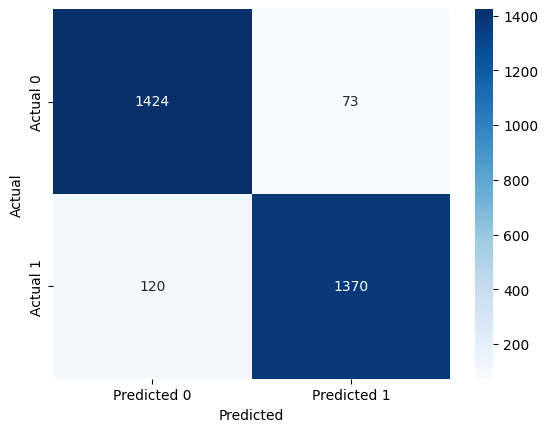

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Ploting the roc_curve

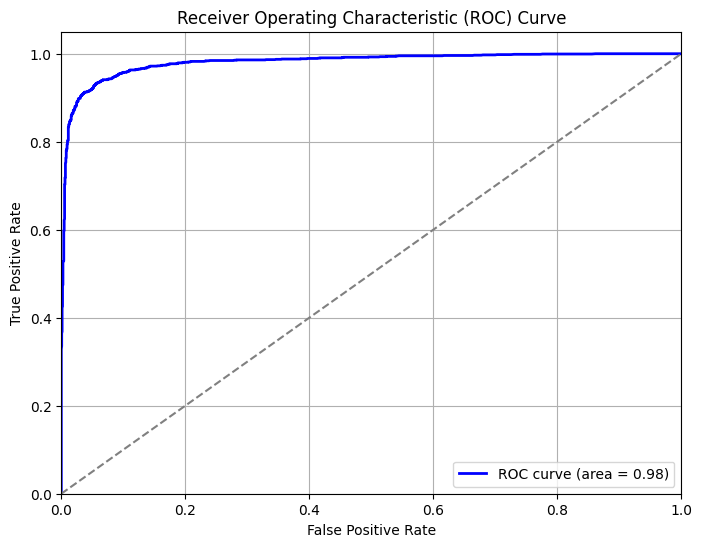

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Evaluate the model
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions  # This should be the raw prediction probabilities
y_true = test_dataset['labels'].numpy()

# Assuming binary classification with probabilities for both classes
# Use the probability of the positive class (index 1) for ROC calculation
y_pred_prob = y_pred[:, 1]  # Extracting the probabilities for the positive class

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)  # Optional: Add grid for better readability
plt.show()


## Save the model and tokenizer

The model and tokenizer are saved in the directory you specify in the save_pretrained method. In the code example provided, the model and tokenizer are saved in the ./saved_model directory relative to the current working directory where the script is executed

In [ ]:
saved_model_path = './saved_model'
model.save_pretrained(saved_model_path)
tokenizer.save_pretrained(saved_model_path)

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

# OTHERS

## List the contents of the saved model directory
 You can verify the saved files by checking the ./saved_model directory. This directory should contain the following files:
config.json: Configuration file for the model.
pytorch_model.bin: The model's weights.
tokenizer_config.json: Configuration file for the tokenizer.
vocab.txt: Vocabulary file used by the tokenizer.
special_tokens_map.json

## To trust the prediction results of a BERT model
To trust the prediction results of a BERT model (or any machine learning model), you should evaluate its performance using various metrics and techniques. Here are some steps to help you build confidence in the model's predictions:

## Learning Curves
Plot learning curves to see how the model's performance evolves with the amount of training data and epochs.

## Confusion Matrix
A confusion matrix provides a visual representation of the model's performance by showing the counts of true positive, true negative, false positive, and false negative predictions.

In [ ]:
import os
print("Saved model files:", os.listdir(saved_model_path))

# Load the model and tokenizer
loaded_model = BertForSequenceClassification.from_pretrained(saved_model_path)
loaded_tokenizer = BertTokenizer.from_pretrained(saved_model_path)

Saved model files: ['config.json', 'vocab.txt', 'tokenizer_config.json', 'special_tokens_map.json', 'model.safetensors']


In [ ]:
import matplotlib.pyplot as plt

# Assuming training and validation losses are recorded as lists
# Ensure that `train_loss`, `val_loss`, and `logging_steps` have been collected during training.

plt.figure(figsize=(10, 6))  # Optional: Make the plot larger
plt.plot(logging_steps, train_loss, label='Training Loss', color='blue', marker='o')  # Added color and marker for clarity
plt.plot(logging_steps, val_loss, label='Validation Loss', color='orange', marker='x')  # Added color and marker for clarity
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')  # Optional: Add a title
plt.legend()
plt.grid(True)  # Optional: Add a grid for better readability
plt.show()


NameError: name 'logging_steps' is not defined

<Figure size 1000x600 with 0 Axes>

## Cross-Validation
Use cross-validation to assess the model's performance across different subsets of the data, ensuring that the evaluation is robust and not biased by a particular train-test split.

In [ ]:
from sklearn.model_selection import cross_val_score
from transformers import BertForSequenceClassification

# Assuming you have a scikit-learn compatible pipeline
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
# Use cross_val_score with a compatible classifier pipeline
scores = cross_val_score(your_pipeline, X, y, cv=10, scoring='accuracy')
print(f'Cross-validation scores: {scores}')
print(f'Mean accuracy: {scores.mean()}')

## Model explanation

In [ ]:
pip install shap
import shap

# Assuming you have a trained model and a tokenizer
explainer = shap.Explainer(model, tokenizer)
shap_values = explainer(test_dataset)
shap.summary_plot(shap_values, test_dataset)